In [2]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Flight Data Analysis") \
    .getOrCreate()

In [3]:
# Load the dataset into a DataFrame
flight_data = spark.read.csv("On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2022_1.csv", header=True, inferSchema=True)

In [4]:
# Print the number of rows and columns
print("Number of rows: ", flight_data.count())
print("Number of columns: ", len(flight_data.columns))

# Print the schema of the DataFrame
flight_data.printSchema()

Number of rows:  537902
Number of columns:  110
root
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- FlightDate: date (nullable = true)
 |-- Reporting_Airline: string (nullable = true)
 |-- DOT_ID_Reporting_Airline: integer (nullable = true)
 |-- IATA_CODE_Reporting_Airline: string (nullable = true)
 |-- Tail_Number: string (nullable = true)
 |-- Flight_Number_Reporting_Airline: integer (nullable = true)
 |-- OriginAirportID: integer (nullable = true)
 |-- OriginAirportSeqID: integer (nullable = true)
 |-- OriginCityMarketID: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- OriginState: string (nullable = true)
 |-- OriginStateFips: integer (nullable = true)
 |-- OriginStateName: string (nullable = true)
 |-- OriginWac: integer (nullable = true)
 |-- DestAirportID: i

In [5]:
# Columns of interest for cleaning
columns_of_interest = [
    "Year", "Quarter", "Month", "DayofMonth", "DayOfWeek", "FlightDate",
    "Reporting_Airline", "DOT_ID_Reporting_Airline", "IATA_CODE_Reporting_Airline",
    "Tail_Number", "Flight_Number_Reporting_Airline", "OriginAirportID",
    "Origin", "OriginCityName", "OriginState", "DestAirportID",
    "Dest", "DestCityName", "DestState", "CRSDepTime", "DepTime", "DepDelay",
    "DepDelayMinutes", "DepDel15", "DepTimeBlk", "TaxiOut", "WheelsOff",
    "WheelsOn", "TaxiIn", "CRSArrTime", "ArrTime", "ArrDelay", "ArrDelayMinutes",
    "ArrDel15", "ArrTimeBlk", "CRSElapsedTime", "ActualElapsedTime",
    "AirTime", "Flights", "Distance", "DistanceGroup"
]

# Select relevant columns and drop rows with any missing values
cleaned_data = flight_data.select(columns_of_interest).dropna()

# Remove duplicate rows
cleaned_data = cleaned_data.dropDuplicates()

# Print the number of rows and columns before cleaning
print("Number of rows before cleaning:", flight_data.count())
print("Number of columns before cleaning:", len(flight_data.columns))

# Print the number of rows and columns after cleaning
print("Number of rows after cleaning:", cleaned_data.count())
print("Number of columns after cleaning:", len(cleaned_data.columns))

Number of rows before cleaning: 537902
Number of columns before cleaning: 110
Number of rows after cleaning: 503529
Number of columns after cleaning: 41


In [6]:
# Register the DataFrame as a temporary SQL table
cleaned_data.createOrReplaceTempView("flight_data_temp")

In [7]:
# Query to find the top 5 airlines with the most flights
query = """
    SELECT Reporting_Airline AS Airline, COUNT(*) AS NumFlights
    FROM flight_data_temp
    GROUP BY Reporting_Airline
    ORDER BY NumFlights DESC
    LIMIT 5
"""

# Execute the SQL query
top_airlines = spark.sql(query)

# Show the result
top_airlines.show()

+-------+----------+
|Airline|NumFlights|
+-------+----------+
|     WN|     90859|
|     DL|     66573|
|     AA|     66370|
|     OO|     58651|
|     UA|     42744|
+-------+----------+



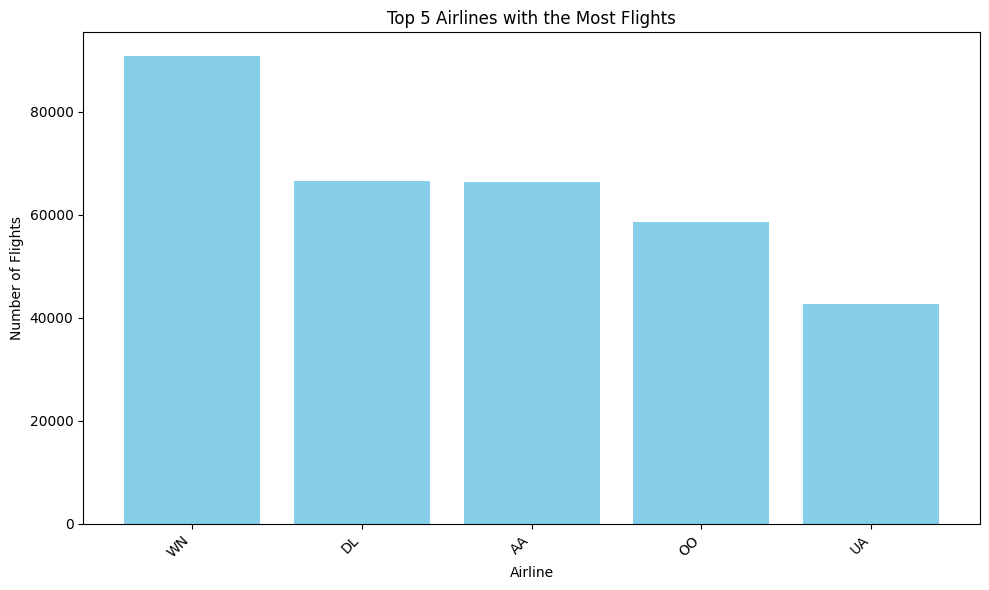

In [13]:
# Extract airline names and number of flights from the DataFrame
airline_names = [row['Airline'] for row in top_airlines.collect()]
num_flights = [row['NumFlights'] for row in top_airlines.collect()]


# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(airline_names, num_flights, color='skyblue')

# Add labels and title
plt.xlabel('Airline')
plt.ylabel('Number of Flights')
plt.title('Top 5 Airlines with the Most Flights')

# Show plot
plt.tight_layout()
plt.show()

In [8]:
# Query to determine the average flight delay by airline
query = """
    SELECT Reporting_Airline AS Airline,
           AVG(ArrDelay) AS AvgDelay
    FROM flight_data_temp
    WHERE ArrDelay IS NOT NULL
    GROUP BY Reporting_Airline
    ORDER BY AvgDelay DESC
"""

# Execute the SQL query
avg_delay_by_airline = spark.sql(query)

# Show the result
avg_delay_by_airline.show()

+-------+--------------------+
|Airline|            AvgDelay|
+-------+--------------------+
|     B6|  18.721081700708627|
|     G4|  12.243134796238245|
|     YV|  11.159475806451614|
|     QX|    10.9645705320957|
|     F9|   10.95516280689535|
|     OH|   10.69882816778009|
|     NK|   8.520167719837005|
|     OO|  7.9284752178138485|
|     HA|   6.884219858156029|
|     AS|   5.233293870034202|
|     UA|   4.756269885831929|
|     YX|  3.3062718486530946|
|     9E|  1.9842539118416507|
|     WN|  1.0503307322334607|
|     DL|-0.22848602286212127|
|     AA| -1.0758324544221787|
|     MQ|  -1.326464157789459|
+-------+--------------------+



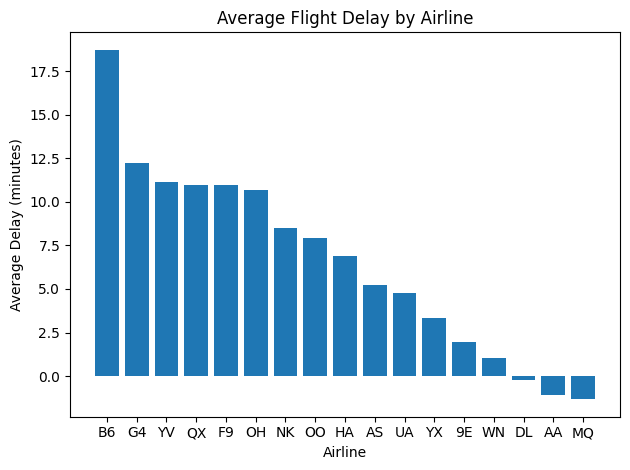

In [16]:
# Extract airline names and average delays from the DataFrame
airline_names = [row['Airline'] for row in avg_delay_by_airline.collect()]
avg_delays = [row['AvgDelay'] for row in avg_delay_by_airline.collect()]

# Create a bar plot
plt.bar(airline_names, avg_delays)

# Add labels and title
plt.xlabel('Airline')
plt.ylabel('Average Delay (minutes)')
plt.title('Average Flight Delay by Airline')

# Show plot
plt.tight_layout()
plt.show()

In [9]:
# Query to identify the top 3 busiest airports
query = """
    SELECT Airport AS Airport,
           SUM(NumFlights) AS TotalFlights
    FROM (
        SELECT Origin AS Airport, COUNT(*) AS NumFlights
        FROM flight_data_temp
        GROUP BY Origin
        UNION ALL
        SELECT Dest AS Airport, COUNT(*) AS NumFlights
        FROM flight_data_temp
        GROUP BY Dest
    ) AS combined_flights
    GROUP BY Airport
    ORDER BY TotalFlights DESC
    LIMIT 3
"""

# Execute the SQL query
top_3_busiest_airports = spark.sql(query)

# Show the result
top_3_busiest_airports.show()

+-------+------------+
|Airport|TotalFlights|
+-------+------------+
|    ATL|       48863|
|    DFW|       44056|
|    DEN|       38708|
+-------+------------+



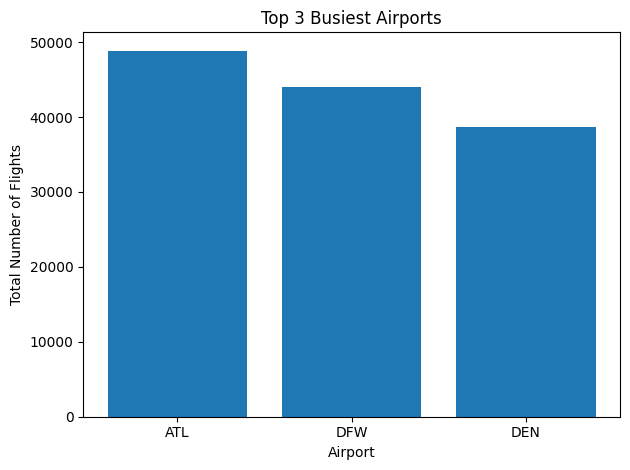

In [21]:
# Extract airport names and total flights from the DataFrame
airport_names = [row['Airport'] for row in top_3_busiest_airports.collect()]
total_flights = [row['TotalFlights'] for row in top_3_busiest_airports.collect()]

# Create a bar plot
plt.bar(airport_names, total_flights)

# Add labels and title
plt.xlabel('Airport')
plt.ylabel('Total Number of Flights')
plt.title('Top 3 Busiest Airports')

# Show plot
plt.tight_layout()
plt.show()

In [10]:
# Query to analyze flight delay pattern across different times of the day
query = """
    SELECT CASE
               WHEN CRSDepTime >= 600 AND CRSDepTime < 1200 THEN 'Morning'
               WHEN CRSDepTime >= 1200 AND CRSDepTime < 1800 THEN 'Afternoon'
               WHEN CRSDepTime >= 1800 AND CRSDepTime < 2400 THEN 'Evening'
               WHEN CRSDepTime >= 0000 AND CRSDepTime < 600 THEN 'Night'
           END AS TimePeriod,
           AVG(ArrDelay) AS AvgDelay
    FROM flight_data_temp
    WHERE ArrDelay IS NOT NULL
    GROUP BY TimePeriod
    ORDER BY TimePeriod
"""

# Execute the SQL query
delay_pattern_by_time_of_day = spark.sql(query)

# Show the result
delay_pattern_by_time_of_day.show()


+----------+------------------+
|TimePeriod|          AvgDelay|
+----------+------------------+
| Afternoon| 5.313496965756394|
|   Evening| 8.014386054763952|
|   Morning|0.6824643354385682|
|     Night|1.0828724431568781|
+----------+------------------+



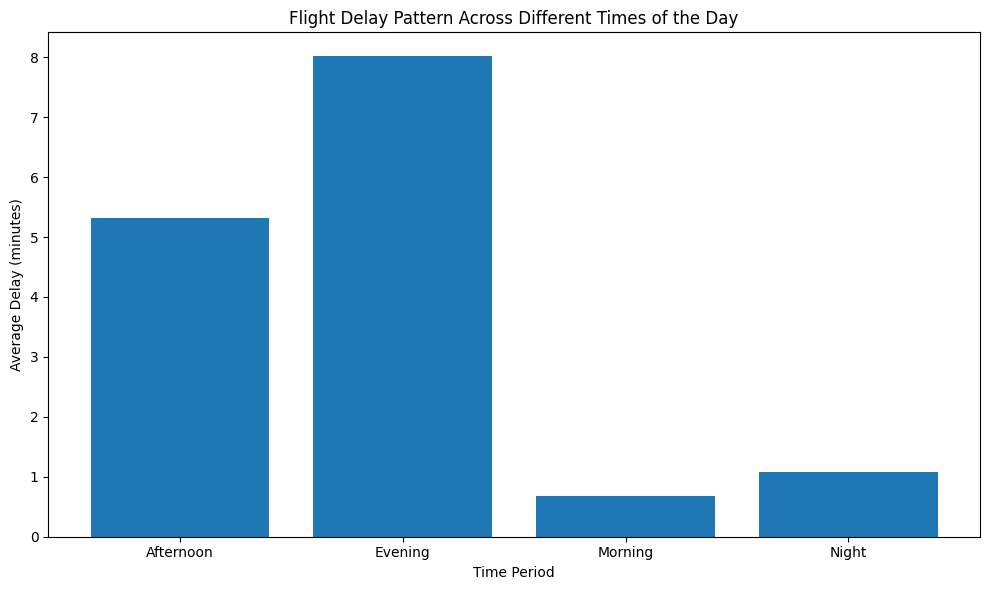

In [18]:
# Extract time periods and average delays from the DataFrame
time_periods = [row['TimePeriod'] for row in delay_pattern_by_time_of_day.collect()]
avg_delays = [row['AvgDelay'] for row in delay_pattern_by_time_of_day.collect()]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(time_periods, avg_delays)

# Add labels and title
plt.xlabel('Time Period')
plt.ylabel('Average Delay (minutes)')
plt.title('Flight Delay Pattern Across Different Times of the Day')

# Show plot
plt.tight_layout()
plt.show()


In [11]:
# Query to find the top 5 routes with the highest average delay
query = """
    SELECT CONCAT(Origin, '-', Dest) AS Route,
           AVG(ArrDelay) AS AvgDelay
    FROM flight_data_temp
    WHERE ArrDelay IS NOT NULL
    GROUP BY Origin, Dest
    ORDER BY AvgDelay DESC
    LIMIT 5
"""

# Execute the SQL query
top_5_delayed_routes = spark.sql(query)

# Show the result
top_5_delayed_routes.show()


+-------+-----------------+
|  Route|         AvgDelay|
+-------+-----------------+
|EGE-LGA|            972.0|
|PHL-PNS|525.6666666666666|
|BWI-SFO|518.3333333333334|
|FCA-SFO|           314.75|
|ATL-ANC|            220.0|
+-------+-----------------+



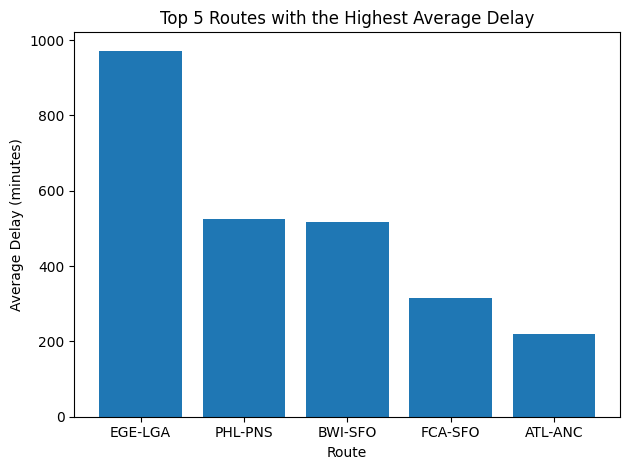

In [20]:
# Extract routes and average delays from the DataFrame
routes = [row['Route'] for row in top_5_delayed_routes.collect()]
avg_delays = [row['AvgDelay'] for row in top_5_delayed_routes.collect()]

# Create a bar plot
plt.bar(routes, avg_delays)

# Add labels and title
plt.xlabel('Route')
plt.ylabel('Average Delay (minutes)')
plt.title('Top 5 Routes with the Highest Average Delay')

# Show plot
plt.tight_layout()
plt.show()